Download the necessary libraries

In [1]:
!pip install --pre scapy[basic]
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the libraries

In [2]:
import time

import numpy as np
import pandas as pd

import json
import socket
from scapy.all import *
import urllib.request

from scipy.optimize import curve_fit
from geopy.distance import geodesic as GD

%matplotlib inline
import matplotlib.pyplot as plt

Now we shall extract the information about the VM from it's public IP address. We will use it's coordinates extracted from the latitude and longtitude as the reference point, wrt which we will later compute the RTT to the servers.

In [3]:
ip_COLAB_PUB = urllib.request.urlopen('https://api.ipify.org').read().decode('UTF-8')
ip_info_COLAB_PUB = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip_COLAB_PUB).read())

print('External IP:', ip_COLAB_PUB)
print('Organization: ', ip_info_COLAB_PUB['org'])
print('Location: ', ip_info_COLAB_PUB['city'], ',', ip_info_COLAB_PUB['country'])

# reference position
lat_COLAB = ip_info_COLAB_PUB['lat']
lon_COLAB = ip_info_COLAB_PUB['lon'] 
print('Latitude:', lat_COLAB, 'Longtitude:', lon_COLAB)

External IP: 34.90.232.204
Organization:  Google Cloud (europe-west4)
Location:  Groningen , Netherlands
Latitude: 53.2193 Longtitude: 6.5665


Now it is time to import the csv file (or generate it) and visualize fitst 10 rows using pandas library and store the file into the dataframe. Dataframe contains 197 servers to be pinged.

In [4]:
def strip_end(text, suffix): # a usefull function to remove a given oart from the right
    if suffix and text.endswith(suffix):
        return text[:-len(suffix)]
    return text

In [5]:
# CHANGE TO GENERATE THE DATASET
download_ds = False # false - upload; true - generate

if download_ds:
    from bs4 import BeautifulSoup as BS # improt for links extraction
    import requests

    html = requests.get('https://www.debian.org/mirror/list.en.html')# get the webpage
    soup = BS(html.text, 'html.parser')# parse using html

    links = soup.select('a')# select all the links

    dataset = []# store the links

    for link in links:# for every link stored
      data = link.get('href')# to string
      if data != None and 'http://' in data and '/debian/' in data: # we care only about links to servers with a certain prefix an suffix
        d = data.strip('http://')#remove prefix
        dataset.append(strip_end(d,'/debian' ))#remove suffix and store

    df = pd.DataFrame(dataset, columns=["Name"]).drop_duplicates()# some links are listed twice on the website
    df.to_csv('servers.csv', index=False)
else:
    path = '/content/drive/MyDrive/Colab Notebooks/Network measurements /servers.csv' # may vary depending on your path
    df = pd.read_csv(path)# get csv file

print('Number of servers:',df.shape[0])
df.head(10)

Number of servers: 197


,Name
0,ftp.au.debian.org
1,ftp.at.debian.org
2,ftp.by.debian.org
3,ftp.be.debian.org
4,ftp.br.debian.org
5,ftp.bg.debian.org
6,ftp.cn.debian.org
7,ftp.hr.debian.org
8,ftp.cz.debian.org
9,ftp.dk.debian.org


To compute the RTT time we do the following for every packet: 1)get the info on the location of the server and compute the distance wrt the VM. 2)Create IP/ICMP packet and try sending it. If no answer received, try the same with IP/TCP packet and select a port. If answered is received, compute RTT as the difference between the qwery and the answer time. If no answer received, generate another IP/TCP packet with another port, otherwise consider RTT as NaN. 3)Compute average RTT and 95% confidence bound based on 'c' packets and append it into the list

In [6]:
c = 10 # number of packets
RTT = [] # list of rtt
RTT_conf = [] # list of 95% confidenence intervals for every rtt
dist = [] # list of distances

tcp_ports = [20, 21, 53, 80] # tcp ports (https://it.wikipedia.org/wiki/Porte_TCP_e_UDP_standard)

for i in range(df.shape[0]): # for every server
  print('Server ',i+1,'/', df.shape[0])
  try:
    target = df.iloc[i]['Name'] # get server's name
    target_ip = socket.gethostbyname(target) # get server's ip
    #get the coordinates of the server
    ip_info_target = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+target_ip).read())
    lat_target = ip_info_target['lat']
    lon_target = ip_info_target['lon'] 
    print('Location: ', ip_info_target['city'], ',', ip_info_target['country'])

    dist.append(GD((lat_COLAB, lon_COLAB),(lat_target, lon_target)).km) # get server's distance wrt the VM

    # measure RTT based on 'c' packets
    for k in range(c): # for every packet
        rtt_k = [] # rtt of each packet

        # try ICMP
        packet = IP(dst = target_ip) / ICMP(seq = i)
        ans, unans = sr(packet, verbose = False, timeout=1)

        if len(ans)>0: # ICMP REPLIED
           query = ans[0][0]
           answer = ans[0][1]
           rtt = (answer.time - query.sent_time)*1000
           print(answer.src,'%.2f' % rtt, 'ms')
        # try TCP
        else:
           print("ICMP is not answered, trying TCP")
           for p in tcp_ports: # loop over the possivle tcp ports
               print('TCP port:', p)
               packet = IP(dst = target_ip) / TCP(dport = p, flags = 'S') # try port p
               ans,unans = sr(packet, verbose = False, timeout = 1)

               if len(ans)>0: # if TCP REPLIED
                  query = ans[0][0]
                  answer = ans[0][1]
                  rtt = (answer.time - query.sent_time)*1000
                  print(answer.src,'%.2f' %rtt, 'ms')
                  break # don't try another port
           
           if(p == tcp_ports[-1]) and (len(ans) == 0): # if we reached the last tcp port but still didn't get any reply
               rtt = np.nan
               print("***")
        rtt_k.append(rtt)
        time.sleep(0.5) # to avoid too many requests 429 error
    RTT.append(np.nanmean(rtt_k)) # get the average of the rtt of 'c' packets
    RTT_conf.append(np.std(rtt_k) * 1.96 / math.sqrt(len(rtt_k))) # get the confidence bound
    print('-'*35)
  except socket.gaierror: # some links might not be valid
    print('Name or server not known')   
    print('-'*35)

Server  1 / 197
Location:  Sydney , Australia
103.84.224.37 274.63 ms
103.84.224.37 273.99 ms
103.84.224.37 273.96 ms
103.84.224.37 273.96 ms
103.84.224.37 273.92 ms
103.84.224.37 273.88 ms
103.84.224.37 273.86 ms
103.84.224.37 273.91 ms
103.84.224.37 273.83 ms
103.84.224.37 273.81 ms
-----------------------------------
Server  2 / 197
Location:  Vienna , Austria
213.129.232.18 25.06 ms
213.129.232.18 24.43 ms
213.129.232.18 24.49 ms
213.129.232.18 24.39 ms
213.129.232.18 24.46 ms
213.129.232.18 24.44 ms
213.129.232.18 24.48 ms
213.129.232.18 24.45 ms
213.129.232.18 24.44 ms
213.129.232.18 24.49 ms
-----------------------------------
Server  3 / 197
Location:  Minsk , Belarus
ICMP is not answered, trying TCP
TCP port: 20
TCP port: 21
TCP port: 53
TCP port: 80
***
ICMP is not answered, trying TCP
TCP port: 20
TCP port: 21
TCP port: 53
TCP port: 80
***
ICMP is not answered, trying TCP
TCP port: 20
TCP port: 21
TCP port: 53
TCP port: 80
***
ICMP is not answered, trying TCP
TCP port: 20
TC

<ipython-input-6-528769ff220b>:54: RuntimeWarning: Mean of empty slice
  RTT.append(np.nanmean(rtt_k))#get the average of the rtt of 'c' packets


-----------------------------------
Server  4 / 197
Location:  Sint-Truiden , Belgium
195.234.45.114 17.98 ms
195.234.45.114 17.19 ms
195.234.45.114 17.10 ms
195.234.45.114 17.29 ms
195.234.45.114 17.08 ms
195.234.45.114 17.14 ms
195.234.45.114 26.75 ms
195.234.45.114 17.02 ms
195.234.45.114 17.22 ms
195.234.45.114 17.19 ms
-----------------------------------
Server  5 / 197
Location:  Curitiba , Brazil
200.236.31.3 205.27 ms
200.236.31.3 204.61 ms
200.236.31.3 204.62 ms
200.236.31.3 204.62 ms
200.236.31.3 204.64 ms
200.236.31.3 204.64 ms
200.236.31.3 204.55 ms
200.236.31.3 204.59 ms
200.236.31.3 204.57 ms
200.236.31.3 204.57 ms
-----------------------------------
Server  6 / 197
Location:  Enschede , Netherlands
130.89.148.12 7.58 ms
130.89.148.12 6.83 ms
130.89.148.12 6.81 ms
130.89.148.12 6.78 ms
130.89.148.12 6.88 ms
130.89.148.12 6.79 ms
130.89.148.12 6.79 ms
130.89.148.12 6.90 ms
130.89.148.12 6.79 ms
130.89.148.12 6.75 ms
-----------------------------------
Server  7 / 197
Locat

Since we haven't taken into account the location wrt the reference so far, we will reorder the data using 'argsort' function and convert everything to a numpy array. Since for some points we may have RTT as NaN (server has not replied to a single message, like 'Belarus' or 'Iran'), we will remove those points from the total statistics.


In [31]:
dist_sorted = np.array(dist)[np.argsort(dist)] # sort wrt the distance (increasing order)
RTT_sorted = np.array(RTT)[np.argsort(dist)]
RTT_conf_sorted = np.array(RTT_conf)[np.argsort(dist)]

# remove NaNs
dist_sorted = dist_sorted[~np.isnan(RTT_sorted)]
RTT_sorted = RTT_sorted[~np.isnan(RTT_sorted)]
RTT_conf_sorted = RTT_conf_sorted[~np.isnan(RTT_conf_sorted)]

Import some tools for plotting

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


speed_of_light = 300_000 # km/s <-for comparison

Now let's visualize the data and try to find linear appriximation to the results. We can try to use 'polyfit' function of numpy for this.

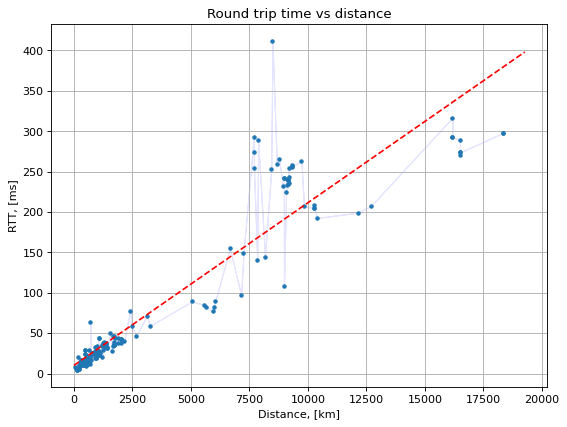

In [41]:
# fit RTT = 2(L/C + d/v) + n -> RTT = 2d/v
xp = np.linspace(0, 1.05*dist_sorted.max(),2)
z = np.polyfit(dist_sorted,RTT_sorted, 1) # slope of the polynomial contains the speed
RTT_lin = np.poly1d(z) # function which takes distance as input and computes RTT


plt.figure(figsize=(8, 6), dpi=80)
plt.plot(dist_sorted, RTT_sorted,'.', xp, RTT_lin(xp), '--r') 
plt.fill_between(dist_sorted, np.array(RTT_sorted) - np.array(RTT_conf_sorted), 
                     np.array(RTT_sorted) + np.array(RTT_conf_sorted), color='b', alpha=0.1, )

plt.xlabel("Distance, [km]")
plt.ylabel("RTT, [ms]")
plt.grid(visible=True)
plt.title('Round trip time vs distance')

plt.show()

In [24]:
z # slope and bias

array([ 0.02013663, 10.12623895])

In [25]:
speed = 10**3*(2/z[0])
print('Transmission speed is','%.2f' % speed, '[km/s], which is ', '%.2f' % (speed_of_light/speed),' times smaller than the speed of light' )

Transmission speed is 99321.51 [km/s], which is  3.02  times smaller than the speed of light


Polyfit funnction consideres the polynomial with an offset, therefore trying to estimate 2 values a and b in y = ax+b. We know, that for the zero distance, the RTT must be appriximately zero, therefore we can to enforce b=0 (although this term can be taken into account as noise, the further plottings are done just for the reference).

We can try to use the least square estimation of the parameters a and b(=0).

In [26]:
A = np.vstack([dist_sorted, np.zeros(len(dist_sorted))]).T
a, b = np.linalg.lstsq(A, RTT_sorted,rcond=None)[0]
print(a,b)

0.02122125343004923 0.0


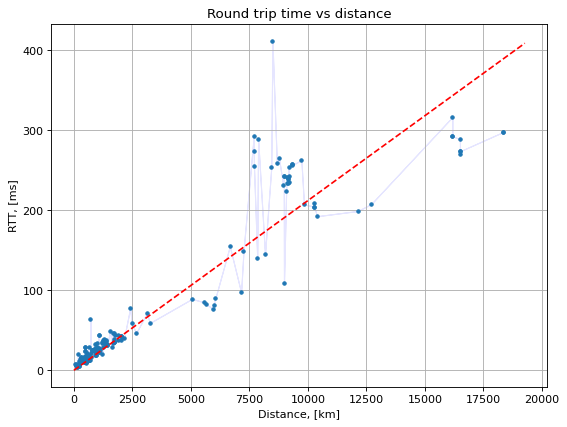

In [40]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(dist_sorted, RTT_sorted,'.', xp, a*xp+b, '--r') 
plt.fill_between(dist_sorted, np.array(RTT_sorted) - np.array(RTT_conf_sorted), 
                     np.array(RTT_sorted) + np.array(RTT_conf_sorted), color='b', alpha=0.1, )

plt.xlabel("Distance, [km]")
plt.ylabel("RTT, [ms]")
plt.grid(visible=True);
plt.title('Round trip time vs distance')

plt.show()

In [28]:
# ms = km;    km/ms -> 10**3  km/s
speed = 10**3*(2/a)
print('Transmission speed is','%.2f' % speed, '[km/s], which is ', '%.2f' % (speed_of_light/speed),' times smaller than the speed of light' )

Transmission speed is 94245.14 [km/s], which is  3.18  times smaller than the speed of light


The other approach would be to establish the needed polynomial and use the function 'curve_fit' of scipy library


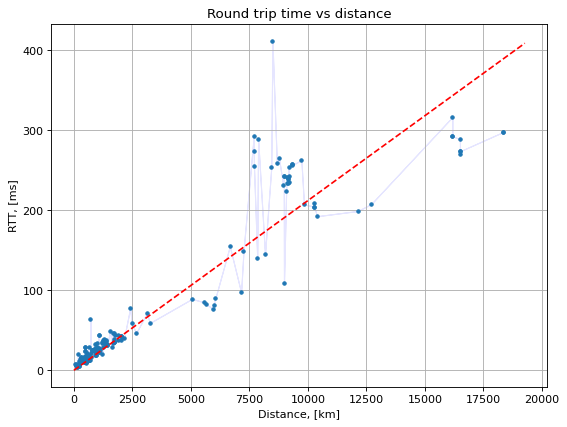

In [39]:
def fit_func(x, a):
    # Curve fitting function
    return a * x  # b=0 is implied

params = curve_fit(fit_func, dist_sorted, RTT_sorted)
a = params[0]

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(dist_sorted, RTT_sorted,'.', xp, a*xp, '--r') 
plt.fill_between(dist_sorted, np.array(RTT_sorted) - np.array(RTT_conf_sorted), 
                     np.array(RTT_sorted) + np.array(RTT_conf_sorted), color='b', alpha=0.1, )

plt.xlabel("Distance, [km]")
plt.ylabel("RTT, [ms]")
plt.grid(visible=True)
plt.title('Round trip time vs distance')

plt.show()

In [20]:
# ms = km;    km/ms -> 10**3 km/s
speed = 10**3*(2/a)
print('Transmission speed is', '%.2f' % speed, '[km/s], which is ', '%.2f' % (speed_of_light/speed),' times smaller than the speed of light')

Transmission speed is 94245.14 [km/s], which is  3.18  times smaller than the speed of light


Both of the methods return approximately the same results. But do these results make sence? They provide the reasonable order of magnitude wrt the speed of light. On the other hand, the results are not exactly the same, because the end points are not connected in a straight line, therefore the actual path is longer, thus the difference in the estimated speed. Bsased on this we can say, that on average, the path a packet takes is 3 times larger than the direct distance between two end points. Note, that all the methods are relatively equal, but this is observed at night. If the notebook is run at midday, the offset in polyfit is more noticable.
